분석할 때 순서
1. 데이터 전처리 단계
2. 감성 분석
3. 주요 주제 추출
4. 문장 및 키워드 분석
5. 유사 리뷰 군집화
6. 워드 클라우드
7. 데이터 시각화
8. 결과 요약 및 인사이트 도출

- 전처리
1. 특수문자 제거
2. 불용어 제거
3. 어간 추출 및 표제어 추출
4. 소문자화

2. 감성분석
고급 머신러닝 모델:

Random Forest, SVM(Support Vector Machine) 등 다양한 머신러닝 모델도 감성 분석에 적합할 수 있습니다. 특히 SVM은 텍스트 분류에서 높은 정확도를 보이는 경우가 많습니다.
이러한 모델들은 로지스틱 회귀보다 복잡한 결정 경계를 학습할 수 있으므로, 데이터의 다양성이 클 때 좋은 성능을 보일 수 있습니다.
딥러닝 모델:

LSTM, GRU: 리뷰와 같은 순차적 데이터를 분석할 때는 순환 신경망(RNN) 기반의 모델이 효과적일 수 있습니다. 이는 문맥을 고려해 단어 간의 관계를 이해할 수 있어 더 정밀한 감성 분석이 가능합니다.
BERT, KoBERT: 트랜스포머 기반의 언어 모델은 문맥을 매우 잘 반영하여 단어의 감정을 정확하게 파악할 수 있습니다. KoBERT는 한국어 텍스트에 최적화되어 있으며, 텍스트의 복잡한 감정도 잘 분석할 수 있습니다.
사전 기반 분석:

감성 사전을 사용해 단어별 긍정, 부정 점수를 부여하는 방법도 효과적일 수 있습니다. 특히 작은 데이터셋에서 학습하는 것이 어려울 때 유용합니다.
KOSAC 등 한국어에 맞는 감성 사전을 사용할 수 있습니다.


- 감정 단어 리스트(예: 긍정어와 부정어)를 추가하여 Review 열에서 해당 단어를 파악하는 방법이 효과적

In [1]:
# !pip install wordcloud matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from wordcloud import WordCloud
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_csv('./data/한강수_reviews_추천순.csv')

In [ ]:
data

In [5]:
data = data.drop(['Index'], axis=1)

In [6]:
data

,Date,Review
0,2024년 10월 8일 화요일,동네 친구들이랑 한잔하러 왔어요\n주차하기 편하고 고기 질 좋고 가성비 좋아요😊😊
1,2024년 7월 31일 수요일,강남 뱅뱅매장 뒤편에 위치해있습미당~\n고기집으로 퀄리티가 좋고 맛도 좋아용\n점심...
2,2024년 10월 12일 토요일,"모두 친철하시고, 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요~👍🏻"
3,2024년 10월 29일 화요일,굿
4,2024년 9월 6일 금요일,굿
...,...,...
99,2019년 8월 9일 금요일,너므친절하시고 살치살 맛잇어용
100,2019년 6월 27일 목요일,등심 맛있어요 단체 회식으로 먹었지만 모두 만족했습니다~
101,2019년 6월 4일 화요일,이제 오픈한 집이라 깨끗하고 고기의 질도 매우 좋았습니다! 번창하세요!
102,2019년 2월 1일 금요일,육회비빕밥 시키면 국도 한그릇 같이 나와유 존맛탱


# 불용어 제거

# 특수문자 제거

In [7]:
import re

# 특수 문자 제거 함수 수정: '\n'도 제거하도록 업데이트
def clean_special_characters(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))

# 새로운 불용어 리스트 정의
stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름"
]

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 텍스트를 공백을 기준으로 나눈 후, stopwords에 포함되지 않은 단어들만 다시 결합
    return ' '.join([word for word in text.split() if word not in stopwords])

# 특수 문자 제거 적용
data['Cleaned_Review'] = data['Review'].apply(clean_special_characters)

# 불용어 제거 적용
data['No_Stopwords_Review'] = data['Cleaned_Review'].apply(remove_stopwords)

# 결과 확인
print(data[['Cleaned_Review', 'No_Stopwords_Review']].head())


                                      Cleaned_Review  \
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요   
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...   
2               모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요   
3                                                  굿   
4                                                  굿   

                                 No_Stopwords_Review  
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요  
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...  
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요  
3                                                  굿  
4                                                  굿  


# 어간 추출 및 표제어 추출

1. Mecab
2. Komoran
3. Kkma (꼬꼬마)
4. Hannanum (한나눔)
5. Eunjeon (은전한닢)
6. KoNLPy 라이브러리
7. 품사 태깅 및 딥러닝 기반 형태소 분석기

추천 분석기 비교 요약:
- Mecab: 속도와 정확도에서 우수하여 대규모 데이터 처리에 추천.
- Komoran: 안정적인 품사 태깅, 빠른 속도로 적당한 분석기.
- Kkma: 구체적인 구문 분석이 필요할 때 유용하지만 속도가 느림.
- Hannanum: 다양한 분석을 지원하지만 속도 면에서 느릴 수 있음.
- 딥러닝 모델 (KoBERT 등): 문맥을 이해한 고차원적인 분석을 수행할 때 사용, 그러나 형태소 분석에는 과할 수 있음.

상황에 따른 추천:
- 속도와 대량 데이터 처리가 중요하다면: Mecab 추천.
- 정확한 품사 태깅과 안정성이 필요하다면: Komoran 추천.
- 복잡한 문장 구조를 분석해야 한다면: Kkma 추천.
- 딥러닝 기반의 문맥적 분석을 원한다면: KoBERT 또는 트랜스포머 기반 접근법을 고려.

# Mecab으로 형태소 분리

In [8]:
from konlpy.tag import Mecab

# Mecab 객체 생성
mecab = Mecab()

# 어간 추출 및 표제어 추출을 위한 함수 정의
def extract_stems(text):
    # Mecab을 이용하여 형태소 분석을 수행하고, 각 단어의 어간을 추출
    morphs = mecab.morphs(text)
    return ' '.join(morphs)

# 'No_Stopwords_Review' 열에 어간 추출 및 표제어 추출 적용
data['Stemmed_Review'] = data['No_Stopwords_Review'].apply(extract_stems)

# 결과 확인
print(data[['No_Stopwords_Review', 'Stemmed_Review']].head())


                                 No_Stopwords_Review  \
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요   
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...   
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요   
3                                                  굿   
4                                                  굿   

                                      Stemmed_Review  
0  동네 친구 들 이랑 한잔 하 러 왔 어요 주차 하 기 편하 고 고기 질 좋 고 가 ...  
1  강남 뱅뱅 매장 뒤편 에 위치 해 있 습 미당 고기 집 으로 퀄리티 가 좋 고 맛 ...  
2       모두 친 철 하 시 고 고기 질 뿐 만 아니 라 반찬 하나 하나 까지 맛있 어요  
3                                                  굿  
4                                                  굿  


띄어쓰기 없이 다시 결합하는 방법

- SVM 모델을 적용하는 과정
1. TF-IDF 벡터화
전처리된 텍스트 데이터를 수치 데이터로 변환하여 모델의 입력으로 사용합니다.

2. SVM 모델 학습 및 평가
SVM 모델을 사용해 긍정과 부정 리뷰를 분류합니다. 이를 위해 데이터를 훈련용과 테스트용으로 나누고, 모델 학습 후 성능을 평가합니다.

In [12]:
!pip install imbalanced-learn


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [13]:
print(data['Sentiment'].value_counts())

Sentiment
1.0    87
0.0     1
Name: count, dtype: int64


In [17]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 부정 샘플을 수동으로 추가하여 데이터의 불균형 문제를 해결
additional_negative_samples = pd.DataFrame({
    'Stemmed_Review': ["별로였음", "돈 아까움", "최악의 경험", "시간 낭비", "다신 안 감", "불만족", "실망스러움", "품질 불량"],  # 부정적인 리뷰 예시
    'Sentiment': [0, 0, 0, 0, 0, 0, 0, 0]  # 부정 레이블
})

# 기존 데이터에 부정 샘플 추가
data = pd.concat([data, additional_negative_samples], ignore_index=True)

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data['Stemmed_Review'])
y = data['Sentiment']

# SMOTE를 이용해 클래스 균형 조정
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# SVM 모델 학습
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        15
    Positive       1.00      1.00      1.00        20

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



In [18]:
# 긍정 및 부정 단어 리스트
# 확장된 최신 긍정 단어 목록
positive_words = [
    "좋", "훌륭", "최고", "맛있", "추천", "즐겁", "기쁘", "만족", "감동", "깨끗", "재밌", "친절",
    "감사", "좋아하", "편안", "행복", "깔끔", "존맛", "JMT", "맛집", "짱", "베스트", "대박",
    "최애", "힐링", "감탄", "인생", "역대급", "완벽", "신선", "든든", "엄지 척", "배려", "뿌듯",
    "포근", "추천템", "안심", "만족도 최고", "편리", "세련", "유용", "아늑", "기대 이상", "고급지다",
    "센스있", "특별", "화려", "러블리", "맛보장", "행운", "예쁘다", "베리 굿", "가성비 좋", "적극 추천",
    "감성적", "취향저격", "레전드", "완소", "쏘 스윗", "찐행복", "갓성비", "귀엽", "최애템", "핵꿀잼",
    "고급미", "갓벽", "미쳤다", "오져", "대만족", "찐사랑", "신박", "고퀄", "강추", "존좋", "너무 좋",
    "죽인다", "굿굿", "금손", "소확행", "최상급", "훈훈", "신세계", "고급짐", "재구매 의사", "초강추",
    "귀엽고 예쁨", "찐템", "꿀템", "신박하다", "행복함", "안심됨", "극호", "꾸안꾸", "손맛 좋",
    "핵감동", "친근감", "든든함", "사랑스러움", "행복사", "찐최애", "만점템", "찐인생템", "눈호강",
    "청정구역", "맑고 깨끗", "깨알재미", "귀염", "사랑스럽다", "가성비템", "깔쌈", "베리굿", "딱 좋음",
    "잘 나감", "편의성 굿", "안정적", "배부름", "센스 만점", "짱짱맨", "적극적", "말해 뭐해", "넘사벽",
    "신뢰감", "꿀잼보장", "심쿵", "센스 넘침", "재미짐", "편리함", "만족스러움", "무한 감동", "탄탄함",
    "우수함", "굿", "존맛탱구리", "ㄴㅇㅅ", "내돈내산", "또방문", "재방문 의사 있", "유명", "소문낼",
    "유명한 이유가 있", "돈 값을 하는", "충족", "ㄱㅇㄷ", "개이득", "최상", "킹왕짱", "행복함",
    "맛집 인정", "찐맛", "호불호 없음", "득템각", "부담없", "소장각", "갓템", "마음에 쏙", "신뢰성",
    "마음에 든다", "푹신함", "대존맛", "신의 한 수",  "극찬",
    "알차다", "취향존중", "무조건 추천", "고급", "실속 있음", "잘 맞음", "너무 예쁘다",
    "믿고 구매", "만족감", "쓸모있음", "매력있음", "비교불가", "퀄리티 갑", "최상의 선택", "역시 좋다", "손이 가요",
    "가치 있음", "핫플", "핵추천", "혜자" "품질보장", "끝내줌", "강력 추천", "금방 동남",
    "엄지척", "거의 완벽", "찬사받음", "감동적", "눈이 즐거움", "존예", 
    "정말 좋아요", "불만 없음", "깔끔한 마무리", "퀄리티 짱", "세상 최고", "매력적", "끝내줌", "눈물남",
    "현존 최고", "좋은 선택", "짱짱", "상상초월", "미친 가성비", "저렴한데 좋음", "찐", "돈 값함",
    "인정", "핵만족", "보장된 품질", "칭찬할 만함", "행운템", "아기자기함", "다시 가고 싶음",
    "핵감사", "짱짱짱", "여긴 진짜다"
]


# 확장된 최신 부정 단어 목록
negative_words = [
    "나쁘", "별로", "싫", "최악", "불편", "문제", "실망", "불만", "안좋", "안되", "부족", "힘들",
    "비싸", "짜증", "불친절", "후회", "아쉽", "형편없", "엉망", "답답", "지루", "불쾌", "피곤",
    "귀찮", "못하", "어렵", "복잡", "짜증나", "실수", "기대 이하", "아깝", "화나", "무례", "미흡",
    "고통", "시끄럽", "안타깝", "낡", "지저분", "아프", "헛걸음", "속상", "똥손", "후지", "망",
    "버거움", "별로임", "바가지", "낙후", "불량", "헛돈", "극혐", "대충", "불쾌한 경험",
    "비추", "별로네", "허접", "노답", "구려", "폐급", "구리다", "짜증 폭발", "돈낭비", "헬", "멘붕",
    "분노", "허접하다", "불편함", "답답함", "현타", "먹튀", "짜증남", "신경쓰임", "헛돈", "개노답",
    "한심", "쌩돈", "쓰레기", "이딴", "어설프다", "오류 많음", "형편없음", "허무함", "낭비", "아쉬움",
    "개판", "헬게이트", "어이없음", "대실망", "구림", "후회막급", "서비스 엉망", "좌절", "불편하다",
    "무리수", "취소각", "짜증만땅", "불만족", "더럽다", "화가남", "찝찝", "바가지", "속터짐", "별로다",
    "실망스러움", "별로에요", "스트레스", "무책임", "노잼", "먹금", "못난", "오바임", "과대광고",
    "구라", "실망임", "불만족스럽", "개노답", "망했", "못하겠", "허접쓰", "오지랖", "지저분함",
    "헛소리", "오류투성이", "피곤함", "서비스 엉망진창", "예민함", "답없다", "과함", "잔소리",
    "번거로움", "불완전", "뻘짓", "정떨어짐", "영혼 없음", "허술함", "제자리", "정리안됨", "답이 없음",
    "빈약함", "불친절한 응대", "뻔뻔", "낙후됨", "어이상실", "시간낭비", "멀미", "부실함", "막장임",
    "헛고생", "최악의 경험", "실망감", "엉망진창", "걱정됨", "재방문 의사 없", "개노맛", "실망각",
    "차라리 안 샀음", "먹다 버림", "재구매 없음", "헛돈 날림", "버림", "답답함", "후회함", "개망",
    "터무니없", "형편 없음", "퀄리티 떨어짐", "돈 아까움", "상태 불량", "비효율적", "쓸모없음",
    "버림", "품질 저하", "오바스러움", "가성비 별로", "마음에 안 듦", "손해", "완전 별로", "무의미",
    "효율성 없음", "가치 없음", "엉성함", "재방문 안함", "비추함", "믿고 걸러", "두 번 다시", "안 맞음",
    "어이없다", "구매 비추천", "완전 구림", "불량품", "기대와 다름", "불쾌감", "미스", "절대 비추",
    "낭비된 돈", "비추요", "이 돈값 못함", "싼 게 비지떡", "텅텅", "돈값 못함", "손해봤다",
    "별로였음", "너무 별로", "돈 아까움", "실망", "안간다", "차라리 딴데", "속았음",
    "후회만 남음", "맘 상함", "한 번 가고 안 감", "사기템", "버림", "쓰레기템", "더러움",
    "터무니 없음", "낚임", "두 번은 안 감", "쓰레기 서비스", "불안함", "서비스 미숙", "당황스러움",
    "너무 느림", "후회만 가득", "갈 이유 없음", "마음 상함", "말도 안 됨", "너무 허접", "없어서 못감",
    "체감상 별로", "기분 상함", "하자 많음", "최악의 결정", "구매 후회", "안습", "저렴한 티", "헛된 시간",
    "망함", "지저분", "두 번 안 감", "손해봄", "싼 맛에 샀는데 후회", "기대보다 별로", "차라리 안 사는 게",
    "기분 상함", "아무것도 아님", "안 사는 게 나음", "갓성비 아님", "여기만 빼고 다 좋음", "진절머리",
    "진저리", "별로다 못해 최악", "위생이 별로"
]


# 레이블 정의 (가정: 긍정(1), 부정(0))
data['Sentiment'] = data['Stemmed_Review'].apply(
    lambda x: 1 if any(word in x for word in positive_words) else 
              (0 if any(word in x for word in negative_words) else None)
)

# NaN 값 제거 (긍정이나 부정 단어가 없는 경우)
data = data.dropna(subset=['Sentiment'])

# 학습을 위한 데이터 준비
X = data['Stemmed_Review']
y = data['Sentiment']

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# SVM 모델 학습
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        17
    Positive       1.00      1.00      1.00        19

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [19]:
from sklearn.model_selection import cross_val_score

# 교차 검증 수행
scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"교차 검증 정확도: {scores.mean()} ± {scores.std()}")


교차 검증 정확도: 1.0 ± 0.0


주요 주제 추출

TF-IDF, LDA(잠재 디리클레 할당)와 같은 주제 모델링 기법

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 리뷰 데이터 준비
reviews = data['Stemmed_Review']

# 1. TF-IDF로 주요 키워드 추출
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # 단어 및 바이그램 분석
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

# TF-IDF 상위 키워드 추출
def extract_top_keywords(tfidf_matrix, tfidf_vectorizer, top_n=10):
    keywords = []
    for i in range(tfidf_matrix.shape[0]):
        row_data = tfidf_matrix[i].toarray().flatten()
        top_indices = row_data.argsort()[-top_n:][::-1]
        top_keywords = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indices]
        keywords.append(top_keywords)
    return keywords

data['Top_Keywords'] = extract_top_keywords(tfidf_matrix, tfidf_vectorizer)

# 2. LDA를 이용한 주제 분류
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# 주요 토픽 추출
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words)
    return topics

no_top_words = 10
topics = display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)

# 결과 확인
print("TF-IDF 기반 주요 키워드:", data[['Stemmed_Review', 'Top_Keywords']].head())
print("LDA 기반 주요 토픽:")
for i, topic in enumerate(topics):
    print(f"토픽 {i + 1}: {topic}")


TF-IDF 기반 주요 키워드:                                       Stemmed_Review  \
0  동네 친구 들 이랑 한잔 하 러 왔 어요 주차 하 기 편하 고 고기 질 좋 고 가 ...   
1  강남 뱅뱅 매장 뒤편 에 위치 해 있 습 미당 고기 집 으로 퀄리티 가 좋 고 맛 ...   
2       모두 친 철 하 시 고 고기 질 뿐 만 아니 라 반찬 하나 하나 까지 맛있 어요   
3                                                  굿   
4                                                  굿   

                                        Top_Keywords  
0  [동네, 동네 친구, 이랑 한잔, 주차 편하, 어요 주차, 친구, 친구 이랑, 편하...  
1  [메뉴, 점심, 매장 뒤편, 메뉴 아서, 아서 푸짐, 위치, 위치 미당, 최애, 메...  
2  [하나, 고기 아니, 까지 맛있, 아니 반찬, 모두 고기, 하나 하나, 하나 까지,...  
3  [100, 훌륭 어요, 훌륭 사장, 훌륭 가져가, 훌륭, 후식 메뉴, 후식, 회식 ...  
4  [100, 훌륭 어요, 훌륭 사장, 훌륭 가져가, 훌륭, 후식 메뉴, 후식, 회식 ...  
LDA 기반 주요 토픽:
토픽 1: ['아요', '최고', '최고 최고', '시간', '낭비', '시간 낭비', '최악의 경험', '최악의', '경험', '밑반찬']
토픽 2: ['맛있 어요', '어요', '맛있', '실망스러움', '불만족', '사장', '친절', '사장 친절', '신선', '신선 맛있']
토픽 3: ['가성', '고기', '는데', '네요', '살치', '살치 어용', '므친절하시고 살치', '어용', '므친절하시고', '육비 최고']
토픽 4: ['습니다', '맛있', '맛있 습니다', '고기', '고기 입니다', '어요 고기', '특히

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# 긍정 및 부정 리뷰 데이터 분리
positive_reviews = data[data['Sentiment'] == 1]['Stemmed_Review']
negative_reviews = data[data['Sentiment'] == 0]['Stemmed_Review']

def extract_topics(reviews, n_topics=5, n_top_words=10):
    # TF-IDF 벡터화
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    
    # LDA 모델 적용
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)
    
    # 주요 키워드 추출
    feature_names = tfidf_vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"토픽 {topic_idx + 1}: {', '.join(top_words)}")
    return topics

# 긍정 리뷰의 주요 토픽
positive_topics = extract_topics(positive_reviews)
print("긍정 리뷰 주요 토픽:")
for topic in positive_topics:
    print(topic)

# 부정 리뷰의 주요 토픽
negative_topics = extract_topics(negative_reviews)
print("\n부정 리뷰 주요 토픽:")
for topic in negative_topics:
    print(topic)


긍정 리뷰 주요 토픽:
토픽 1: 아요, 습니다, 맛있, 세요, 최고, 반찬, 모두, 친절, 불만족, 고기
토픽 2: 고기, 어요, 는데, 묘했, 맛나, 이번, 칼칼, 고추, 했으면, 청양
토픽 3: 아서, 으로, 아용, 고기, 직원, 점심, 친절, 다양, 가격, 성비
토픽 4: 어요, 맛있, 고기, 신선, 사장, 점심때, 친절, 새우, 특히, 가져가
토픽 5: 영양, 가성, 맛집, 한우, 입니다, 된장찌개, 친절, 고기, 맛있, 점심

부정 리뷰 주요 토픽:
토픽 1: 낭비, 시간, 품질, 불량, 별로였음, 아까움, 실망스러움, 최악의, 경험, 으로
토픽 2: 아까움, 별로였음, 실망스러움, 품질, 불량, 시간, 낭비, 최악의, 경험, 으로
토픽 3: 실망스러움, 별로였음, 아까움, 품질, 불량, 시간, 낭비, 최악의, 경험, 으로
토픽 4: 최악의, 경험, 별로였음, 아까움, 실망스러움, 불량, 품질, 낭비, 시간, 으로
토픽 5: 별로였음, 주차, 입니다, 주차장, 으로, 매장, 불편, 자리, 가셔야, 거의


문장 및 키워드 분석
유사 리뷰 군집화
워드 클라우드
데이터 시각화
결과 요약 및 인사이트 도출

주요 키워드를 워드 클라우드

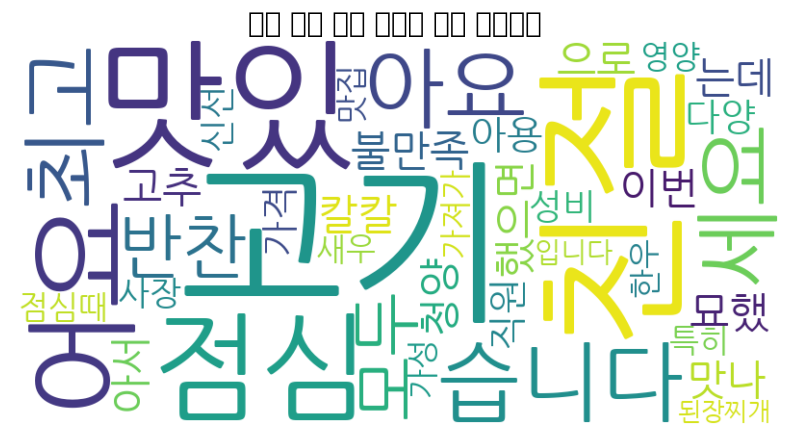

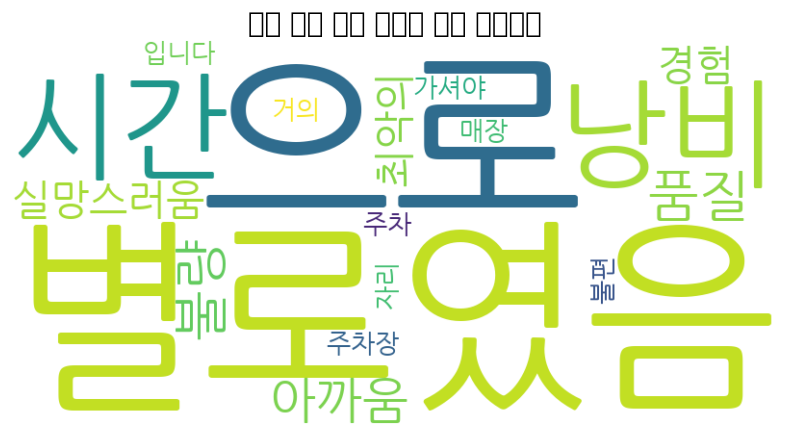

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 설정 (Ubuntu 시스템의 예)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

def create_wordcloud(keywords, title):
    # 키워드 리스트를 하나의 문자열로 결합
    text = ' '.join(keywords)
    # 워드 클라우드 생성 (font_path 추가)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path=font_path).generate(text)
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# 긍정 리뷰 주요 키워드 워드 클라우드
positive_keywords = [word for topic in positive_topics for word in topic.split(': ')[1].split(', ')]
create_wordcloud(positive_keywords, '긍정 리뷰 주요 키워드 워드 클라우드')

# 부정 리뷰 주요 키워드 워드 클라우드
negative_keywords = [word for topic in negative_topics for word in topic.split(': ')[1].split(', ')]
create_wordcloud(negative_keywords, '부정 리뷰 주요 키워드 워드 클라우드')


In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 경로 설정 (Ubuntu 시스템의 예)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib에 폰트 경로 설정
rc('font', family='NanumGothic')

def create_wordcloud(text, title):
    # 워드 클라우드 생성 (font_path 추가)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path=font_path).generate(text)
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# 전체 리뷰 텍스트 결합
all_reviews_text = ' '.join(data['Stemmed_Review'])

# 전체 리뷰 워드 클라우드 생성
create_wordcloud(all_reviews_text, '전체 리뷰 워드 클라우드')


AssertionError: phrase input should be string, not <class 'float'>

In [ ]:
# Mecab 객체 생성
mecab = Mecab()

# 어간 추출 및 형태소 분석 후 조사 제거 함수 정의
def extract_stems_and_remove_josa(text):
    # Mecab을 이용하여 형태소 분석을 수행하고, 조사를 제거
    words = mecab.pos(text)
    filtered_words = [word for word, pos in words if pos not in ['JKS', 'JKB', 'JKC', 'JKG', 'JKO', 'JKV', 'JC']]
    return ' '.join(filtered_words)

# 'No_Stopwords_Review' 열에 어간 추출 및 조사 제거 적용
data['Stemmed_Review'] = data['No_Stopwords_Review'].apply(extract_stems_and_remove_josa)

# 형태소 분석 후 불용어 제거 다시 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_stopwords)

# 단어 길이 1 이하인 단어 제거 함수 정의
def remove_short_words(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

# 단어 길이에 따른 필터링 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_short_words)

# 결과 확인
print(data[['No_Stopwords_Review', 'Stemmed_Review']].head())

# 전체 리뷰 텍스트 결합
all_reviews_text = ' '.join(data['Stemmed_Review'])

# 워드 클라우드 생성
create_wordcloud(all_reviews_text, '전체 리뷰 워드 클라우드')


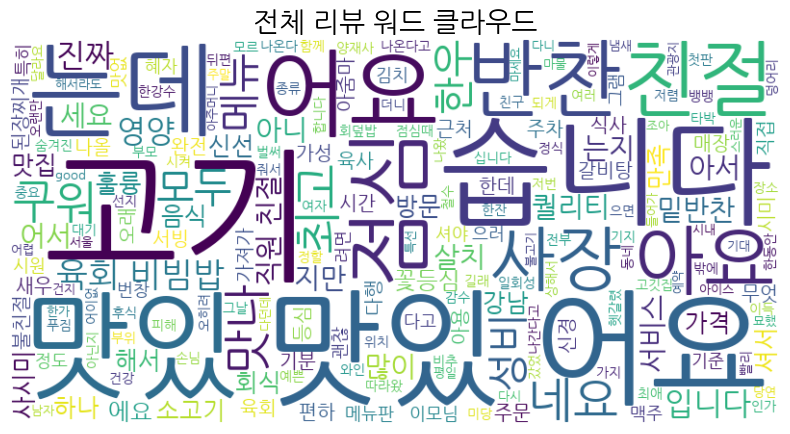

In [2]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rc

# CSV 파일 로드
data = pd.read_csv('./data/한강수_reviews_추천순.csv')

# 'Index' 열 제거 (있을 경우)
if 'Index' in data.columns:
    data = data.drop(['Index'], axis=1)

# 특수 문자 제거 함수 수정: '\n'도 제거하도록 업데이트
def clean_special_characters(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))

# 새로운 불용어 리스트 정의
stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름"
]

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 텍스트를 공백을 기준으로 나눈 후, stopwords에 포함되지 않은 단어들만 다시 결합
    return ' '.join([word.strip() for word in text.split() if word.strip() not in stopwords])

# 특수 문자 제거 적용
data['Cleaned_Review'] = data['Review'].apply(clean_special_characters)

# 불용어 제거 적용
data['No_Stopwords_Review'] = data['Cleaned_Review'].apply(remove_stopwords)

# Mecab 객체 생성
mecab = Mecab()

# 어간 추출 및 형태소 분석 후 조사 제거 함수 정의
def extract_stems_and_remove_josa(text):
    # Mecab을 이용하여 형태소 분석을 수행하고, 조사를 제거
    words = mecab.pos(text)
    filtered_words = [word for word, pos in words if pos not in ['JKS', 'JKB', 'JKC', 'JKG', 'JKO', 'JKV', 'JC']]
    return ' '.join(filtered_words)

# 'No_Stopwords_Review' 열에 어간 추출 및 조사 제거 적용
data['Stemmed_Review'] = data['No_Stopwords_Review'].apply(extract_stems_and_remove_josa)

# 형태소 분석 후 불용어 제거 다시 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_stopwords)

# 단어 길이 1 이하인 단어 제거 함수 정의
def remove_short_words(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

# 단어 길이에 따른 필터링 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_short_words)

# NaN 값을 빈 문자열로 대체
data['Stemmed_Review'] = data['Stemmed_Review'].fillna('')

# 문자열이 아닌 값을 필터링하여 공백으로 대체
data['Stemmed_Review'] = data['Stemmed_Review'].apply(lambda x: x if isinstance(x, str) else '')

# 워드 클라우드 생성 함수 정의
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
rc('font', family='NanumGothic')

def create_wordcloud(text, title):
    # 워드 클라우드 생성 (font_path 추가)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path=font_path).generate(text)
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# 전체 리뷰 텍스트 결합
all_reviews_text = ' '.join(data['Stemmed_Review'])

# 전체 리뷰 워드 클라우드 생성
create_wordcloud(all_reviews_text, '전체 리뷰 워드 클라우드')


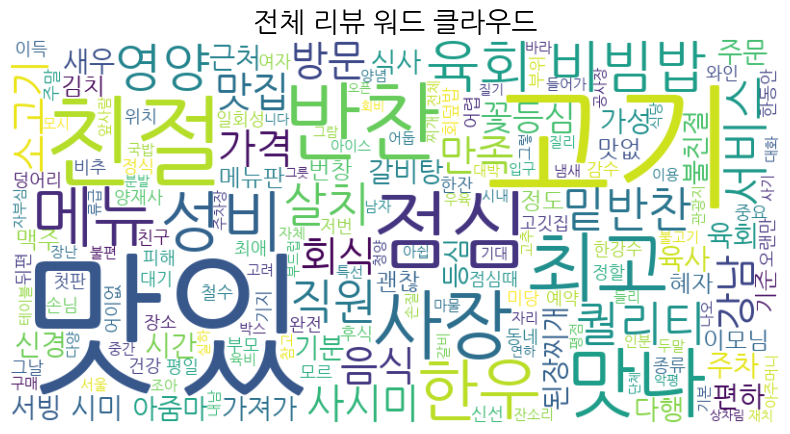

In [3]:
from konlpy.tag import Mecab

# Mecab 객체 생성
mecab = Mecab()

# 어간 추출 및 형태소 분석 후 조사 제거 함수 정의
def extract_stems_and_remove_josa(text):
    # Mecab을 이용하여 형태소 분석을 수행하고, 필요 없는 품사 제거
    words = mecab.pos(text)
    filtered_words = []
    for word, pos in words:
        # 동사(VV), 형용사(VA)는 어간만 추출하여 사용
        if pos in ['VV', 'VA']:
            filtered_words.append(mecab.morphs(word)[0])
        # 일반 명사(NNG, NNP)도 포함
        elif pos in ['NNG', 'NNP']:
            filtered_words.append(word)
    return ' '.join(filtered_words)

# 'No_Stopwords_Review' 열에 어간 추출 및 조사 제거 적용
data['Stemmed_Review'] = data['No_Stopwords_Review'].apply(extract_stems_and_remove_josa)

# 형태소 분석 후 불용어 제거 다시 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_stopwords)

# 단어 길이 1 이하인 단어 제거 함수 정의
def remove_short_words(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

# 단어 길이에 따른 필터링 적용
data['Stemmed_Review'] = data['Stemmed_Review'].apply(remove_short_words)

# NaN 값을 빈 문자열로 대체
data['Stemmed_Review'] = data['Stemmed_Review'].fillna('')

# 문자열이 아닌 값을 필터링하여 공백으로 대체
data['Stemmed_Review'] = data['Stemmed_Review'].apply(lambda x: x if isinstance(x, str) else '')

# 워드 클라우드 생성 함수 정의
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
rc('font', family='NanumGothic')

def create_wordcloud(text, title):
    # 워드 클라우드 생성 (font_path 추가)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path=font_path).generate(text)
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# 전체 리뷰 텍스트 결합
all_reviews_text = ' '.join(data['Stemmed_Review'])

# 전체 리뷰 워드 클라우드 생성
create_wordcloud(all_reviews_text, '전체 리뷰 워드 클라우드')


In [14]:
# !pip install numpy==1.24.3

In [10]:
# !pip install gensim

In [20]:
# !pip uninstall numpy -y
# !pip install numpy==1.21.6

In [19]:
!pip install scipy==1.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 69.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.14.4 requires numpy<3,>=1.22.3, but you have numpy 1.21.6 which is incompatible.
statsmodels 0.14.4 requires scipy!=1.9.2,>=1.8, but you have scipy 1.7.3 which is incompatible.


/tmp/ipykernel_26746/2806706042.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


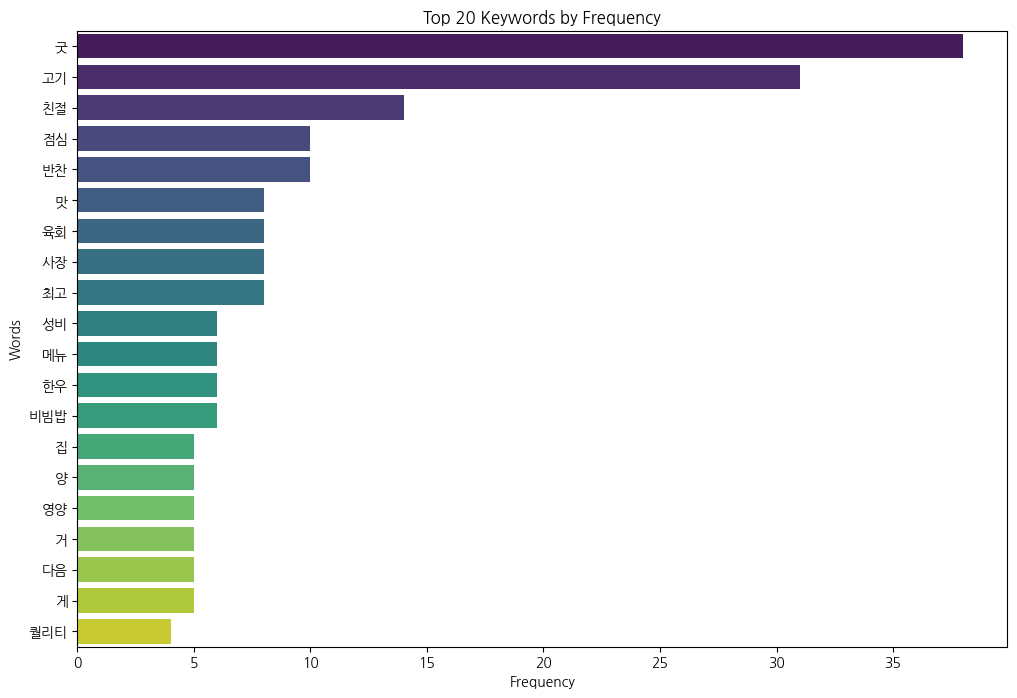

/tmp/ipykernel_26746/2806706042.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')


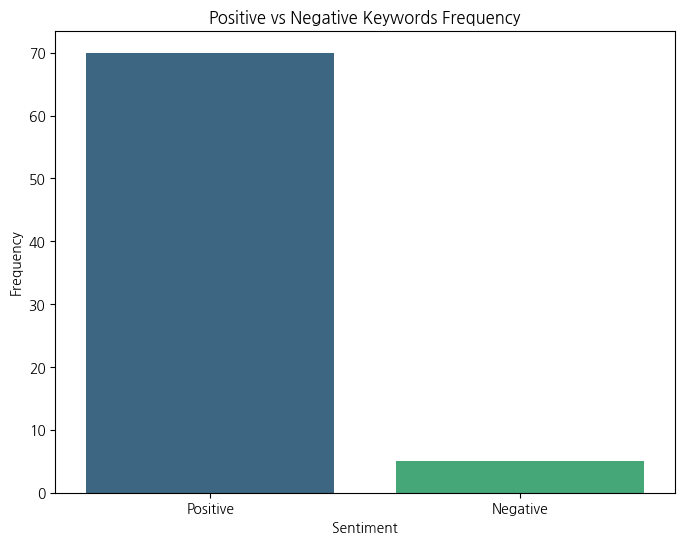

LDA 기반 주요 토픽:
토픽 1: ['친절', '점심', '소고기', '밑반찬', '육회', '직원', '직원 친절', '밑반찬 다양', '다양', '육비']
토픽 2: ['고기', '친절', '살치', '회식', '고기 반찬', '강남', '회비 그릇', '회비', '그릇', '주차']
토픽 3: ['새우', '최고', '최고 최고', '고기', '류급', '밑반찬 류급', '청양 고추', '청양', '고추', '갈비탕']
토픽 4: ['가성', '조아', '사시미 구매', '구매', '사시미', '니다 사장', '고기 꽃등심', '꽃등심 니다', '니다', '기준']
토픽 5: ['영양', '사장', '친절', '사장 친절', '고기', '점심때', '반찬', '육회', '육회 비빔밥', '비빔밥']


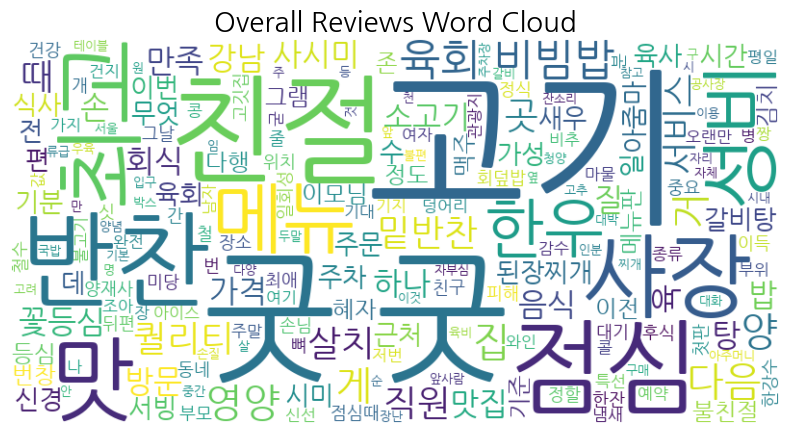

In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import datetime
from matplotlib import font_manager, rc
from konlpy.tag import Mecab

# 한글 폰트 설정 (예: 나눔고딕)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 폰트 파일 경로를 맞게 설정해 주세요
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 그래프에서 마이너스 폰트 깨짐 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# Load the data
data = pd.read_csv('./data/한강수_reviews_추천순.csv')

# 'Date' 열을 'Review_Date'로 변경하고 datetime 형식으로 변환
data['Review_Date'] = pd.to_datetime(data['Date'], format='%Y년 %m월 %d일 %A', errors='coerce')

# Preprocessing steps (special character removal, stopword removal)
def clean_special_characters(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))

def remove_stopwords(text, stopwords):
    return ' '.join([word.strip() for word in text.split() if word.strip() not in stopwords])

stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름", "습니다", "니다", "이고", "해요", "가요",
    "한동안", "오랜만"
]

data['Cleaned_Review'] = data['Review'].apply(clean_special_characters)
data['No_Stopwords_Review'] = data['Cleaned_Review'].apply(lambda x: remove_stopwords(x, stopwords))

# Mecab 객체 생성
mecab = Mecab()

# 형태소 분석 후 명사만 추출하는 함수 정의
def extract_nouns(text):
    return ' '.join(mecab.nouns(text))

# 명사만 추출하여 리뷰 데이터 업데이트
data['Nouns_Only_Review'] = data['No_Stopwords_Review'].apply(extract_nouns)

# 1. 빈도 기반 중요도 분석 - 상위 키워드 시각화
def plot_top_keywords(text_data, title, top_n=20):
    words = ' '.join(text_data).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

plot_top_keywords(data['Nouns_Only_Review'], 'Top 20 Keywords by Frequency')

# 2. 긍정 단어와 부정 단어 빈도 분석
positive_words = [
    "좋", "훌륭", "최고", "맛있", "추천", "즐겁", "기쁘", "만족", "감동", "깨끗", "재밌", "친절",
    "감사", "좋아하", "편안", "행복", "깔끔", "존맛", "JMT", "맛집", "짱", "베스트", "대박",
    "최애", "힐링", "감탄", "인생", "역대급", "완벽", "신선", "든든", "엄지 척", "배려", "뿌듯",
    "포근", "추천템", "안심", "만족도 최고", "편리", "세련", "유용", "아늑", "기대 이상", "고급지다",
    "센스있", "특별", "화려", "러블리", "맛보장", "행운", "예쁘다", "베리 굿", "가성비 좋", "적극 추천",
    "감성적", "취향저격", "레전드", "완소", "쏘 스윗", "찐행복", "갓성비", "귀엽", "최애템", "핵꿀잼",
    "고급미", "갓벽", "미쳤다", "오져", "대만족", "찐사랑", "신박", "고퀄", "강추", "존좋", "너무 좋",
    "죽인다", "굿굿", "금손", "소확행", "최상급", "훈훈", "신세계", "고급짐", "재구매 의사", "초강추",
    "귀엽고 예쁨", "찐템", "꿀템", "신박하다", "행복함", "안심됨", "극호", "꾸안꾸", "손맛 좋",
    "핵감동", "친근감", "든든함", "사랑스러움", "행복사", "찐최애", "만점템", "찐인생템", "눈호강",
    "청정구역", "맑고 깨끗", "깨알재미", "귀염", "사랑스럽다", "가성비템", "깔쌈", "베리굿", "딱 좋음",
    "잘 나감", "편의성 굿", "안정적", "배부름", "센스 만점", "짱짱맨", "적극적", "말해 뭐해", "넘사벽",
    "신뢰감", "꿀잼보장", "심쿵", "센스 넘침", "재미짐", "편리함", "만족스러움", "무한 감동", "탄탄함",
    "우수함", "굿", "존맛탱구리", "ㄴㅇㅅ", "내돈내산", "또방문", "재방문 의사 있", "유명", "소문낼",
    "유명한 이유가 있", "돈 값을 하는", "충족", "ㄱㅇㄷ", "개이득", "최상", "킹왕짱", "행복함",
    "맛집 인정", "찐맛", "호불호 없음", "득템각", "부담없", "소장각", "갓템", "마음에 쏙", "신뢰성",
    "마음에 든다", "완소템", "힐링템", "푹신함", "대존맛", "신의 한 수", "필수템", "사길 잘함", "극찬",
    "알차다", "취향존중", "무조건 추천", "고급", "실속 있음", "잘 맞음", "너무 예쁘다",
    "만족함", "매력있음", "비교불가", "퀄리티 갑", "최상의 선택", "역시 좋다", "손이 가요",
    "가치 있음", "핫플", "핵추천", "혜자템", "품질보장", "끝내줌", "강력 추천", "금방 동남",
    "엄지척", "거의 완벽", "찬사받음", "너무 예쁨", "감동적", "눈이 즐거움", "존맛", "핫템",
    "정말 좋아요", "불만 없음", "깔끔한 마무리", "퀄리티 짱", "세상 최고", "매력적", "끝내줌", "눈물남",
    "현존 최고", "좋은 선택", "짱짱", "상상초월", "미친 가성비", "저렴한데 좋음", "찐", "돈 값함",
    "인정", "핵만족", "보장된 품질", "칭찬할 만함", "행운템", "아기자기함", "다시 가고 싶음",
    "핵감사", "짱짱짱", "여긴 진짜다"
]
negative_words = [
    "나쁘", "별로", "싫", "최악", "불편", "문제", "실망", "불만", "안좋", "안되", "부족", "힘들",
    "비싸", "짜증", "불친절", "후회", "아쉽", "형편없", "엉망", "답답", "지루", "불쾌", "피곤",
    "귀찮", "못하", "어렵", "복잡", "짜증나", "실수", "기대 이하", "아깝", "화나", "무례", "미흡",
    "고통", "시끄럽", "안타깝", "낡", "지저분", "아프", "헛걸음", "속상", "똥손", "후지", "망",
    "버거움", "별로임", "바가지", "낙후", "불량", "헛돈", "극혐", "잦은 오류", "대충", "불쾌한 경험",
    "비추", "별로네", "허접", "노답", "구려", "폐급", "구리다", "짜증 폭발", "돈낭비", "헬", "멘붕",
    "분노", "허접하다", "불편함", "답답함", "현타", "먹튀", "짜증남", "신경쓰임", "헛돈", "개노답",
    "한심", "쌩돈", "쓰레기", "이딴", "어설프다", "오류 많음", "형편없음", "허무함", "낭비", "아쉬움",
    "개판", "헬게이트", "어이없음", "대실망", "구림", "후회막급", "서비스 엉망", "좌절", "불편하다",
    "무리수", "취소각", "짜증만땅", "불만족", "더럽다", "화가남", "찝찝", "바가지", "속터짐", "별로다",
    "실망스러움", "별로에요", "스트레스", "무책임", "노잼", "먹금", "못난", "오바임", "과대광고",
    "구라", "실망임", "불만족스럽", "개노답", "망했", "못하겠", "허접쓰", "오지랖", "지저분함",
    "헛소리", "오류투성이", "피곤함", "서비스 엉망진창", "예민함", "낙제점", "답없다", "과함", "잔소리",
    "번거로움", "불완전", "뻘짓", "정떨어짐", "영혼 없음", "허술함", "제자리", "정리안됨", "답이 없음",
    "빈약함", "불친절한 응대", "뻔뻔", "낙후됨", "어이상실", "시간낭비", "멀미", "부실함", "막장임",
    "헛고생", "최악의 경험", "실망감", "엉망진창", "걱정됨", "재방문 의사 없", "개노맛", "실망각",
    "차라리 안 샀음", "먹다 버림", "재구매 없음", "헛돈 날림", "버림", "답답함", "후회함", "개망",
    "터무니없", "형편 없음", "망템", "퀄리티 떨어짐", "돈 아까움", "상태 불량", "비효율적", "쓸모없음",
    "버림", "품질 저하", "오바스러움", "가성비 별로", "마음에 안 듦", "손해", "완전 별로", "무의미",
    "효율성 없음", "가치 없음", "엉성함", "재방문 안함", "비추함", "믿고 걸러", "두 번 다시", "안 맞음",
    "어이없다", "구매 비추천", "완전 구림", "불량품", "기대와 다름", "불쾌감", "미스", "절대 비추",
    "낭비된 돈", "비추요", "이 돈값 못함", "바로 반품", "싼 게 비지떡", "텅텅", "돈값 못함", "손해봤다",
    "별로였음", "너무 별로", "비추템", "핵노잼", "돈 아까움", "실망", "안간다", "차라리 딴데", "속았음",
    "후회만 남음", "맘 상함", "믿거템", "한 번 가고 안 감", "사기템", "버림", "쓰레기템", "더러움",
    "터무니 없음", "낚임", "두 번은 안 감", "쓰레기 서비스", "불안함", "서비스 미숙", "당황스러움",
    "너무 느림", "후회만 가득", "갈 이유 없음", "마음 상함", "말도 안 됨", "너무 허접", "없어서 못감",
    "체감상 별로", "기분 상함", "하자 많음", "최악의 결정", "구매 후회", "안습", "저렴한 티", "헛된 시간",
    "망함", "지저분", "두 번 안 감", "손해봄", "싼 맛에 샀는데 후회", "기대보다 별로", "차라리 안 사는 게",
    "기분 상함", "아무것도 아님", "안 사는 게 나음", "갓성비 아님", "여기만 빼고 다 좋음", "진절머리",
    "진저리", "별로다 못해 최악", "위생이 별로"
]

def plot_sentiment_keywords(text_data, positive_words, negative_words, title):
    words = ' '.join(text_data).split()
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

    sentiment_counts = {
        'Positive': positive_count,
        'Negative': negative_count
    }

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_sentiment_keywords(data['Nouns_Only_Review'], positive_words, negative_words, 'Positive vs Negative Keywords Frequency')

# 3. TF-IDF 기반 주요 키워드 추출
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Nouns_Only_Review'])

# 상위 키워드 추출
def extract_top_keywords(tfidf_matrix, tfidf_vectorizer, top_n=10):
    keywords = []
    for i in range(tfidf_matrix.shape[0]):
        row_data = tfidf_matrix[i].toarray().flatten()
        top_indices = row_data.argsort()[-top_n:][::-1]
        top_keywords = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indices]
        keywords.append(top_keywords)
    return keywords

data['Top_Keywords'] = extract_top_keywords(tfidf_matrix, tfidf_vectorizer)

# 4. 주제 모델링 (LDA) 기반 주요 주제 분류
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_matrix)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words)
    return topics

no_top_words = 10
topics = display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)
print("LDA 기반 주요 토픽:")
for i, topic in enumerate(topics):
    print(f"토픽 {i + 1}: {topic}")

# 5. 긍정/부정 리뷰의 비교 - 별도의 워드 클라우드 생성
def create_wordcloud(text, title):
    if not text.strip():
        print(f"No words available for {title}. Skipping word cloud generation.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# positive_reviews = ' '.join(data[data['Nouns_Only_Review'].str.contains('|'.join(positive_words))]['Nouns_Only_Review'])
# negative_reviews = ' '.join(data[data['Nouns_Only_Review'].str.contains('|'.join(negative_words))]['Nouns_Only_Review'])

# create_wordcloud(positive_reviews, 'Positive Reviews Word Cloud')
# create_wordcloud(negative_reviews, 'Negative Reviews Word Cloud')
create_wordcloud(' '.join(data['Nouns_Only_Review']), 'Overall Reviews Word Cloud')

# 6. 시계열 분석 - 리뷰 감성 변화 분석
data = data.dropna(subset=['Review_Date'])
data = data.sort_values('Review_Date')

# 감성 점수 부여 (긍정: 1, 부정: -1)
data['Sentiment_Score'] = data['Nouns_Only_Review'].apply(lambda x: 1 if any(word in positive_words for word in x.split()) else (-1 if any(word in negative_words for word in x.split()) else 0))

# # 시계열 데이터 그룹화 (월별 평균 감성 점수 계산)
# time_series_data = data.set_index('Review_Date').resample('M')['Sentiment_Score'].mean()



In [2]:
import torch
import tensorflow as tf

print(torch.__version__)
print(tf.__version__)


2024-11-11 15:37:14.053466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-11 15:37:14.053524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.1+cu124
2.8.0


In [16]:
!pip install kobert_tokenizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement kobert_tokenizer (from versions: none)
ERROR: No matching distribution found for kobert_tokenizer


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26746/1421667450.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


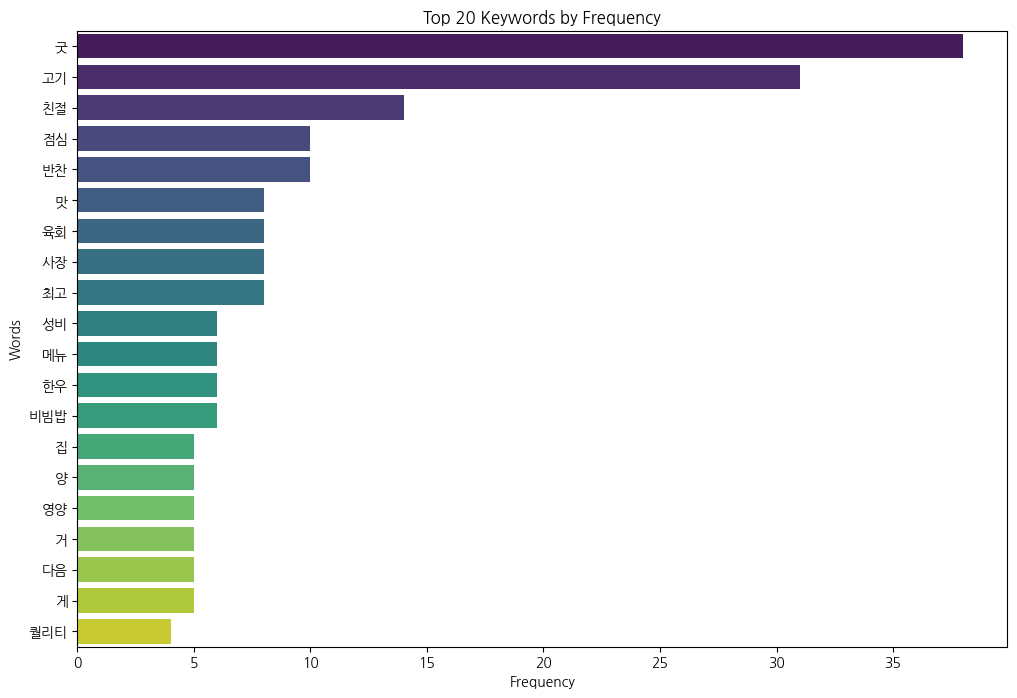

/tmp/ipykernel_26746/1421667450.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')


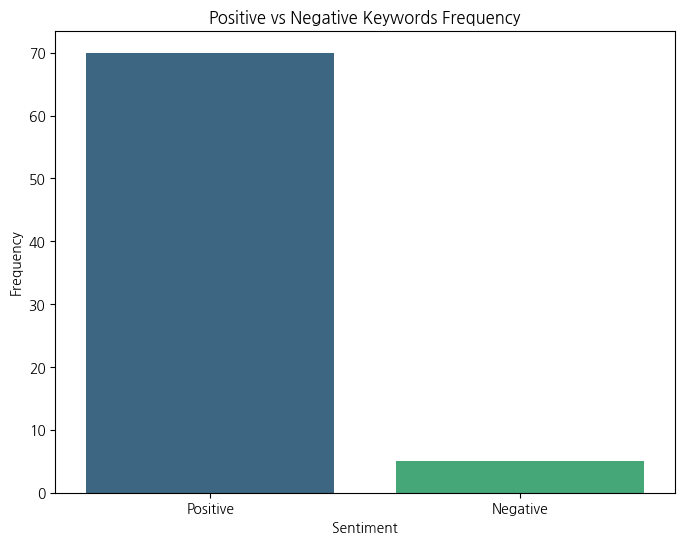

LDA 기반 주요 토픽:
토픽 1: ['친절', '점심', '소고기', '밑반찬', '육회', '직원', '직원 친절', '밑반찬 다양', '다양', '육비']
토픽 2: ['고기', '친절', '살치', '회식', '고기 반찬', '강남', '회비 그릇', '회비', '그릇', '주차']
토픽 3: ['새우', '최고', '최고 최고', '고기', '류급', '밑반찬 류급', '청양 고추', '청양', '고추', '갈비탕']
토픽 4: ['가성', '조아', '사시미 구매', '구매', '사시미', '니다 사장', '고기 꽃등심', '꽃등심 니다', '니다', '기준']
토픽 5: ['영양', '사장', '친절', '사장 친절', '고기', '점심때', '반찬', '육회', '육회 비빔밥', '비빔밥']
No words available for Positive Reviews Word Cloud. Skipping word cloud generation.


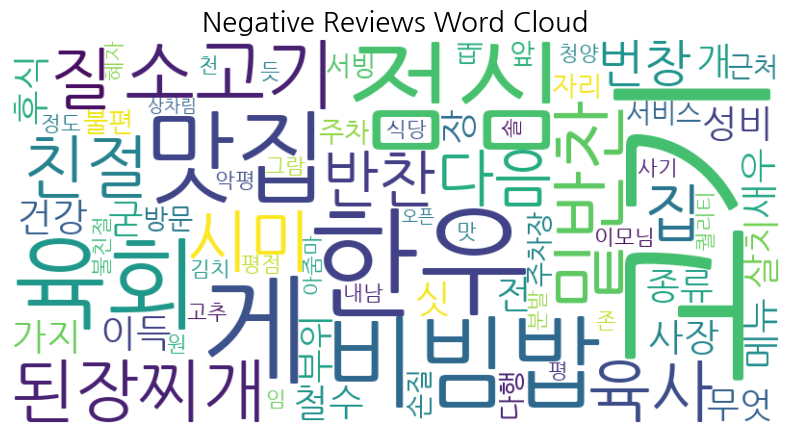

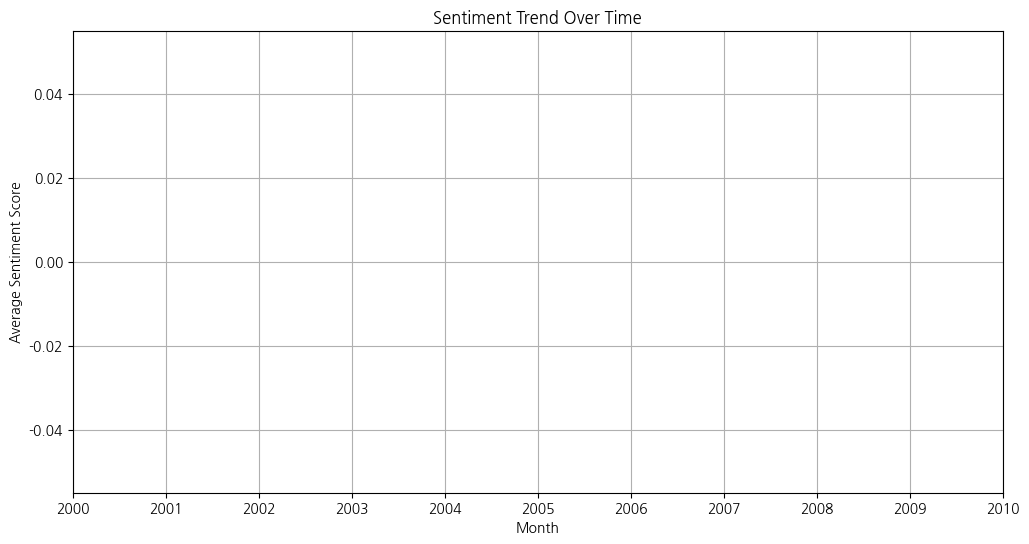

In [18]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import datetime
from matplotlib import font_manager, rc
from konlpy.tag import Mecab
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch
import re

# 한글 폰트 설정 (예: 나눔고딕)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 폰트 파일 경로를 맞게 설정해 주세요
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 그래프에서 마이너스 폰트 깨짐 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# Load the data
data = pd.read_csv('./data/한강수_reviews_추천순.csv')

# 'Date' 열을 'Review_Date'로 변경하고 datetime 형식으로 변환
data['Review_Date'] = pd.to_datetime(data['Date'], format='%Y년 %m월 %d일 %A', errors='coerce')

# Preprocessing steps (special character removal, stopword removal)
def clean_special_characters(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))

def remove_stopwords(text, stopwords):
    return ' '.join([word.strip() for word in text.split() if word.strip() not in stopwords])

stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름", "습니다", "니다", "이고", "해요", "가요",
    "한동안", "오랜만"
]

data['Cleaned_Review'] = data['Review'].apply(clean_special_characters)
data['No_Stopwords_Review'] = data['Cleaned_Review'].apply(lambda x: remove_stopwords(x, stopwords))

# Mecab 객체 생성
mecab = Mecab()

# 형태소 분석 후 명사만 추출하는 함수 정의
def extract_nouns(text):
    return ' '.join(mecab.nouns(text))

# 명사만 추출하여 리뷰 데이터 업데이트
data['Nouns_Only_Review'] = data['No_Stopwords_Review'].apply(extract_nouns)

# KoBERT 모델 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert')

def kobert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label = torch.argmax(probs, dim=1).item()
    if label == 0:
        return 'Negative'
    elif label == 1:
        return 'Neutral'
    else:
        return 'Positive'

# 감성 분석 수행 및 결과 저장
data['Sentiment'] = data['No_Stopwords_Review'].apply(kobert_sentiment_analysis)

# 긍정/부정 리뷰 필터링
data_positive = data[data['Sentiment'] == 'Positive']
data_negative = data[data['Sentiment'] == 'Negative']

# 1. 빈도 기반 중요도 분석 - 상위 키워드 시각화
def plot_top_keywords(text_data, title, top_n=20):
    words = ' '.join(text_data).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

plot_top_keywords(data['Nouns_Only_Review'], 'Top 20 Keywords by Frequency')

# 2. 긍정 단어와 부정 단어 빈도 분석
def plot_sentiment_keywords(text_data, positive_words, negative_words, title):
    words = ' '.join(text_data).split()
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

    sentiment_counts = {
        'Positive': positive_count,
        'Negative': negative_count
    }

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


positive_words = [
    "좋", "훌륭", "최고", "맛있", "추천", "즐겁", "기쁘", "만족", "감동", "깨끗", "재밌", "친절",
    "감사", "좋아하", "편안", "행복", "깔끔", "존맛", "JMT", "맛집", "짱", "베스트", "대박",
    "최애", "힐링", "감탄", "인생", "역대급", "완벽", "신선", "든든", "엄지 척", "배려", "뿌듯",
    "포근", "추천템", "안심", "만족도 최고", "편리", "세련", "유용", "아늑", "기대 이상", "고급지다",
    "센스있", "특별", "화려", "러블리", "맛보장", "행운", "예쁘다", "베리 굿", "가성비 좋", "적극 추천",
    "감성적", "취향저격", "레전드", "완소", "쏘 스윗", "찐행복", "갓성비", "귀엽", "최애템", "핵꿀잼",
    "고급미", "갓벽", "미쳤다", "오져", "대만족", "찐사랑", "신박", "고퀄", "강추", "존좋", "너무 좋",
    "죽인다", "굿굿", "금손", "소확행", "최상급", "훈훈", "신세계", "고급짐", "재구매 의사", "초강추",
    "귀엽고 예쁨", "찐템", "꿀템", "신박하다", "행복함", "안심됨", "극호", "꾸안꾸", "손맛 좋",
    "핵감동", "친근감", "든든함", "사랑스러움", "행복사", "찐최애", "만점템", "찐인생템", "눈호강",
    "청정구역", "맑고 깨끗", "깨알재미", "귀염", "사랑스럽다", "가성비템", "깔쌈", "베리굿", "딱 좋음",
    "잘 나감", "편의성 굿", "안정적", "배부름", "센스 만점", "짱짱맨", "적극적", "말해 뭐해", "넘사벽",
    "신뢰감", "꿀잼보장", "심쿵", "센스 넘침", "재미짐", "편리함", "만족스러움", "무한 감동", "탄탄함",
    "우수함", "굿", "존맛탱구리", "ㄴㅇㅅ", "내돈내산", "또방문", "재방문 의사 있", "유명", "소문낼",
    "유명한 이유가 있", "돈 값을 하는", "충족", "ㄱㅇㄷ", "개이득", "최상", "킹왕짱", "행복함",
    "맛집 인정", "찐맛", "호불호 없음", "득템각", "부담없", "소장각", "갓템", "마음에 쏙", "신뢰성",
    "마음에 든다", "완소템", "힐링템", "푹신함", "대존맛", "신의 한 수", "필수템", "사길 잘함", "극찬",
    "알차다", "취향존중", "무조건 추천", "고급", "실속 있음", "잘 맞음", "너무 예쁘다",
    "만족함", "매력있음", "비교불가", "퀄리티 갑", "최상의 선택", "역시 좋다", "손이 가요",
    "가치 있음", "핫플", "핵추천", "혜자템", "품질보장", "끝내줌", "강력 추천", "금방 동남",
    "엄지척", "거의 완벽", "찬사받음", "너무 예쁨", "감동적", "눈이 즐거움", "존맛", "핫템",
    "정말 좋아요", "불만 없음", "깔끔한 마무리", "퀄리티 짱", "세상 최고", "매력적", "끝내줌", "눈물남",
    "현존 최고", "좋은 선택", "짱짱", "상상초월", "미친 가성비", "저렴한데 좋음", "찐", "돈 값함",
    "인정", "핵만족", "보장된 품질", "칭찬할 만함", "행운템", "아기자기함", "다시 가고 싶음",
    "핵감사", "짱짱짱", "여긴 진짜다"
]
negative_words = [
    "나쁘", "별로", "싫", "최악", "불편", "문제", "실망", "불만", "안좋", "안되", "부족", "힘들",
    "비싸", "짜증", "불친절", "후회", "아쉽", "형편없", "엉망", "답답", "지루", "불쾌", "피곤",
    "귀찮", "못하", "어렵", "복잡", "짜증나", "실수", "기대 이하", "아깝", "화나", "무례", "미흡",
    "고통", "시끄럽", "안타깝", "낡", "지저분", "아프", "헛걸음", "속상", "똥손", "후지", "망",
    "버거움", "별로임", "바가지", "낙후", "불량", "헛돈", "극혐", "잦은 오류", "대충", "불쾌한 경험",
    "비추", "별로네", "허접", "노답", "구려", "폐급", "구리다", "짜증 폭발", "돈낭비", "헬", "멘붕",
    "분노", "허접하다", "불편함", "답답함", "현타", "먹튀", "짜증남", "신경쓰임", "헛돈", "개노답",
    "한심", "쌩돈", "쓰레기", "이딴", "어설프다", "오류 많음", "형편없음", "허무함", "낭비", "아쉬움",
    "개판", "헬게이트", "어이없음", "대실망", "구림", "후회막급", "서비스 엉망", "좌절", "불편하다",
    "무리수", "취소각", "짜증만땅", "불만족", "더럽다", "화가남", "찝찝", "바가지", "속터짐", "별로다",
    "실망스러움", "별로에요", "스트레스", "무책임", "노잼", "먹금", "못난", "오바임", "과대광고",
    "구라", "실망임", "불만족스럽", "개노답", "망했", "못하겠", "허접쓰", "오지랖", "지저분함",
    "헛소리", "오류투성이", "피곤함", "서비스 엉망진창", "예민함", "낙제점", "답없다", "과함", "잔소리",
    "번거로움", "불완전", "뻘짓", "정떨어짐", "영혼 없음", "허술함", "제자리", "정리안됨", "답이 없음",
    "빈약함", "불친절한 응대", "뻔뻔", "낙후됨", "어이상실", "시간낭비", "멀미", "부실함", "막장임",
    "헛고생", "최악의 경험", "실망감", "엉망진창", "걱정됨", "재방문 의사 없", "개노맛", "실망각",
    "차라리 안 샀음", "먹다 버림", "재구매 없음", "헛돈 날림", "버림", "답답함", "후회함", "개망",
    "터무니없", "형편 없음", "망템", "퀄리티 떨어짐", "돈 아까움", "상태 불량", "비효율적", "쓸모없음",
    "버림", "품질 저하", "오바스러움", "가성비 별로", "마음에 안 듦", "손해", "완전 별로", "무의미",
    "효율성 없음", "가치 없음", "엉성함", "재방문 안함", "비추함", "믿고 걸러", "두 번 다시", "안 맞음",
    "어이없다", "구매 비추천", "완전 구림", "불량품", "기대와 다름", "불쾌감", "미스", "절대 비추",
    "낭비된 돈", "비추요", "이 돈값 못함", "바로 반품", "싼 게 비지떡", "텅텅", "돈값 못함", "손해봤다",
    "별로였음", "너무 별로", "비추템", "핵노잼", "돈 아까움", "실망", "안간다", "차라리 딴데", "속았음",
    "후회만 남음", "맘 상함", "믿거템", "한 번 가고 안 감", "사기템", "버림", "쓰레기템", "더러움",
    "터무니 없음", "낚임", "두 번은 안 감", "쓰레기 서비스", "불안함", "서비스 미숙", "당황스러움",
    "너무 느림", "후회만 가득", "갈 이유 없음", "마음 상함", "말도 안 됨", "너무 허접", "없어서 못감",
    "체감상 별로", "기분 상함", "하자 많음", "최악의 결정", "구매 후회", "안습", "저렴한 티", "헛된 시간",
    "망함", "지저분", "두 번 안 감", "손해봄", "싼 맛에 샀는데 후회", "기대보다 별로", "차라리 안 사는 게",
    "기분 상함", "아무것도 아님", "안 사는 게 나음", "갓성비 아님", "여기만 빼고 다 좋음", "진절머리",
    "진저리", "별로다 못해 최악", "위생이 별로"
]


plot_sentiment_keywords(data['Nouns_Only_Review'], positive_words, negative_words, 'Positive vs Negative Keywords Frequency')

# 3. TF-IDF 기반 주요 키워드 추출
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Nouns_Only_Review'])

# 상위 키워드 추출
def extract_top_keywords(tfidf_matrix, tfidf_vectorizer, top_n=10):
    keywords = []
    for i in range(tfidf_matrix.shape[0]):
        row_data = tfidf_matrix[i].toarray().flatten()
        top_indices = row_data.argsort()[-top_n:][::-1]
        top_keywords = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indices]
        keywords.append(top_keywords)
    return keywords

data['Top_Keywords'] = extract_top_keywords(tfidf_matrix, tfidf_vectorizer)

# 4. 주제 모델링 (LDA) 기반 주요 주제 분류
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_matrix)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words)
    return topics

no_top_words = 10
topics = display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)
print("LDA 기반 주요 토픽:")
for i, topic in enumerate(topics):
    print(f"토픽 {i + 1}: {topic}")

# 5. 긍정/부정 리뷰의 비교 - 별도의 워드 클라우드 생성
def create_wordcloud(text, title):
    if not text.strip():
        print(f"No words available for {title}. Skipping word cloud generation.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

positive_reviews = ' '.join(data_positive['Nouns_Only_Review'])
negative_reviews = ' '.join(data_negative['Nouns_Only_Review'])

create_wordcloud(positive_reviews, 'Positive Reviews Word Cloud')
create_wordcloud(negative_reviews, 'Negative Reviews Word Cloud')

# 6. 시계열 분석 - 리뷰 감성 변화 분석
data = data.dropna(subset=['Review_Date'])
data = data.sort_values('Review_Date')

# 감성 점수 부여 (긍정: 1, 부정: -1)
data['Sentiment_Score'] = data['Sentiment'].apply(lambda x: 1 if x == 'Positive' else (-1 if x == 'Negative' else 0))



KoBERT 사용하기

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert')


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KoGPT-2 사용하기

In [9]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

tokenizer = GPT2Tokenizer.from_pretrained('skt/kogpt2-base-v2')
model = GPT2ForSequenceClassification.from_pretrained('skt/kogpt2-base-v2')


TypeError: expected str, bytes or os.PathLike object, not NoneType